In [25]:
'''
This script uses the EV Charging behaviours dataset (xlsx format)
The script aims to explain what factors contribute to charging cost.
It applies classic ML regression and plots the influence of each feature to the end result.
This is a very intresting plot since it gives a good idea of the contribution of each factor.
'''


'\nThis script uses the EV Charging behaviours dataset (xlsx format)\nThe script aims to explain what factors contribute to charging cost.\nIt applies classic ML regression and plots the influence of each feature to the end result.\nThis gives an idea of the contribution.\n'

In [26]:
import numpy as np
import datetime as dt
import sklearn
import pandas as pd
from sklearn import preprocessing 
import os

In [27]:
# read data

df = pd.read_excel (r'Data/EV Charging behaviours.xlsx',sheet_name='enlarged data')
X=df.copy()

In [28]:
# encoding of non numerical data
# NOTE: most of the attributes aren't actually used


from sklearn.preprocessing import OneHotEncoder
le = preprocessing.LabelEncoder()
#X['medewerker'] = le.fit_transform(X['medewerker'])
X['Kaart ID'] = le.fit_transform(X['Kaart ID'])
X['Platform'] = le.fit_transform(X['Platform'])
X['Number plate'] = le.fit_transform(X['Number plate'].astype(str))
#X['car type'] = le.fit_transform(X['car type'].astype(str))
#X['car type'] = X['car type'].astype(str)
X['Locatie'] = le.fit_transform(X['Locatie'])
X['Land'] = le.fit_transform(X['Land'])
#X['AC or DC'] = le.fit_transform(X['AC or DC'])
#X['Laadpaaltype'] = le.fit_transform(X['Laadpaaltype'])
X['Laadpaal_ID'] = le.fit_transform(X['Laadpaal_ID'].astype(str))
X['Laadpaalexploitant'] = le.fit_transform(X['Laadpaalexploitant'].astype(str))
X['Driver has home charger'] = le.fit_transform(X['Driver has home charger'].astype(str))
X['Within office hours'] = le.fit_transform(X['Within office hours'].astype(str))
enc = OneHotEncoder(handle_unknown='ignore')
# passing bridge-types-cat column (label encoded values of bridge_types)
enc_df = pd.DataFrame(enc.fit_transform(X[['Main Office','car type','Weekday']]).toarray())
# merge with main df bridge_df on key values
X = X.join(enc_df)
print(X.shape)

(14330, 74)


In [29]:
#clean data

X=X.dropna()

In [30]:
# Decide what features to take into account in the model

duration = True
percent_charged= True
battery_size=True
percent_laadpaal=False
Geladen_kWh=False
home_charger=True
main_office=True
car_type=True
year=True
weekday=True
within_hours=True
noon=True

In [31]:
# select features

selection=[]
labels=[]

if duration:
    selection.append('Duration in minutes')
if percent_charged:
    selection.append('% of battery charged')
if battery_size:
    selection.append('Battery size')
if percent_laadpaal:
    selection.append('% laadpaal vermogen')
if percent_laadpaal:
    selection.append('Geladen kWh')
if home_charger:
    selection.append('Driver has home charger')
if year:
    selection.append('Year')
if within_hours:
    selection.append('Within office hours')
if noon:
    selection.append('afternoon')
    
    
    
labels=selection.copy()
used_params=selection.copy()
onehot_counter=0


offices=X['Main Office'].unique()
nb_officess=len(offices.tolist())
if main_office:
    classes=[onehot_counter+i for i in range(nb_officess)]
    selection=selection+classes
    labels=labels+offices.tolist()
    used_params.append('Main office')
onehot_counter=onehot_counter+nb_officess

car_types=X['car type'].unique()
nb_car_types=len(car_types.tolist())
if car_type:
    classes=[onehot_counter+i for i in range(nb_car_types)]
    selection=selection+classes
    labels=labels+car_types.tolist()
    used_params.append('car type')
onehot_counter=onehot_counter+nb_car_types

weekdays=X['Weekday'].unique()
nb_weekdays=7
if car_type:
    classes=[onehot_counter+i for i in range(nb_weekdays)]
    selection=selection+classes
    labels=labels+weekdays.tolist()
    used_params.append('Weekday')
onehot_counter=onehot_counter+nb_weekdays

X_selection= X[selection]

In [32]:
# train - validation data split based on individual users

from sklearn import tree
from sklearn.model_selection import train_test_split

users=X["medewerker"]
unique_users=users.unique()

np.random.shuffle(unique_users)
train_users=unique_users[:120]
test_users=unique_users[120:]

X_train_full=X.loc[X['medewerker'].isin(train_users)]
X_test_full=X.loc[X['medewerker'].isin(test_users)]

X_train=X_train_full[selection]
X_test=X_test_full[selection]
y_train=X_train_full['€ / kWh']
y_test=X_test_full['€ / kWh']



In [33]:
# scale data
# regression requires data to be scaled (<=> trees)

scaler = preprocessing.StandardScaler().fit(X_selection)
X_scaled = scaler.transform(X_selection)

In [34]:
# fit model

from sklearn import linear_model
from sklearn.metrics import mean_absolute_error 
from sklearn.model_selection import train_test_split

clf_lin = linear_model.LinearRegression()
clf_lin=clf_lin.fit(X_train, y_train)
y_lin_test=clf_lin.predict(X_test)
y_lin_train=clf_lin.predict(X_train)

print('mean_absolute_error lin test:' + str(mean_absolute_error (y_lin_test,y_test)))
print('mean_absolute_error lin train:' + str(mean_absolute_error (y_lin_train,y_train)))


mean_absolute_error lin test:0.05441502886703998
mean_absolute_error lin train:0.04628587263732982


In [35]:
# get feature coefficients

import numpy as np
coeffs_lin = clf_lin.coef_
comps=coeffs_lin
abs_comp =  np.array([abs(el) for el in comps])
inds=abs_comp.argsort()
vals=[comps[i] for i in inds]
features=[selection[i] for i in inds]
for i in range(len(features)):
    featr=features[i]
    if isinstance(featr, int):
        if featr<=9:
            features[i]=offices[featr]
        elif featr<=29:
            features[i]=car_types[featr-10]
        elif featr<=36:
            features[i]=weekdays[featr-30]
        else:
            features[i]=laadpaaltypes[featr-37]
#print(vals)        
#print(features)

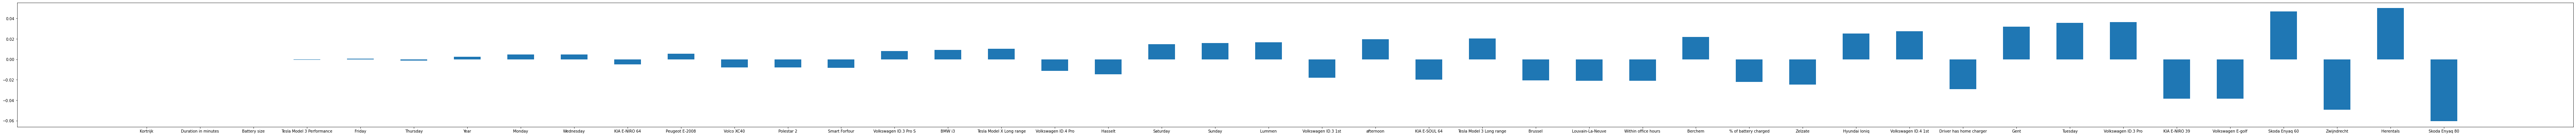

In [36]:
#plot 1

import matplotlib.pyplot as plt
import matplotlib.dates as mdates



plt.figure(figsize=(6*20, 2*3)) 
plt.bar(range(len(vals)), vals, align='center', width=0.5)
plt.xticks(range(len(vals)), features)
plt.savefig(os.path.join('reg_explained_full.png'), dpi=100, format='png',figsize=(50,50))
plt.show()

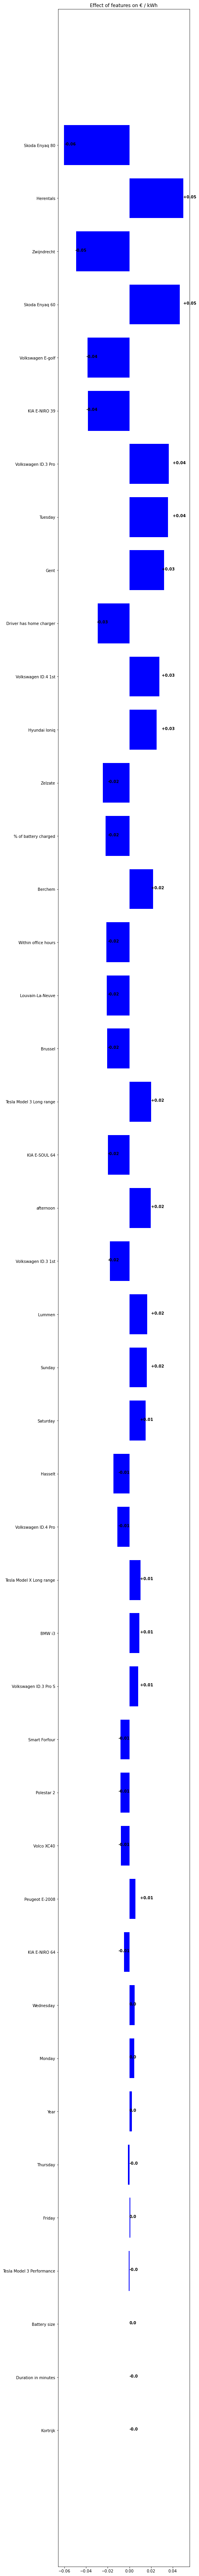

In [37]:
#plot 2

import os
import numpy as np
import matplotlib.pyplot as plt

x = features
y = vals

y_rounded=[round(y,2) for y in vals]
#plt.figure(figsize=(6*20, 2*3))
fig, ax = plt.subplots(figsize=(2*3, 6*20))    
width = 0.75 # the width of the bars 
ind = np.arange(len(y))  # the x locations for the groups
ax.barh(ind+width/2, y, width, color="blue",align='center')
for i, v in enumerate(y_rounded):
    if v>0:
        w="+"+str(v)
    else:
        w=str(v)
    
    ax.text(v, i+width/2, w, color='black', fontweight='bold')
ax.set_yticks(ind+width/2)
ax.set_yticklabels(x, minor=False)
plt.title('Effect of features on € / kWh')
     
#plt.show()

plt.savefig(os.path.join('Effect of features on costprice full.png'), dpi=300, format='png', bbox_inches='tight')